# EDA: Marvel Studios v. Marvel Comics

## Problem Statement

Using data between two subreddits on Reddit, would a Multinomial Naive Bayes model perform better than a Support Vector Machines model to predict which post belonged to the correct subreddit?

## Table of Contents

* [Introduce Datasets](#first-bullet)
* [Exploratory Data Analysis](#second-bullet)
* [Setting Up Data Modeling](#third-bullet)
* [Baseline Accuracy](#fourth-bullet)
* [Modeling with CountVect and Multinomial Naive Bayes](#fifth-bullet)
* [Modeling with TfidfVect and Logistic Regression](#sixth-bullet)
* [Executive Summary](#eighth-bullet)

In [40]:
#imports

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text 

# Import tokenizers and regex

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re     # Python package for regular expressions

## Introduce Datasets <a class="anchor" id="first-bullet"></a>

In [2]:
#Read Data
marvel_url = 'https://raw.git.generalassemb.ly/sampeou/project_3/master/data/marvel_reddit.csv?token=AAAICLGEPKMJGGQ3MBCP2ITADZVOI'
marvelstudios_url = 'https://raw.git.generalassemb.ly/sampeou/project_3/master/data/marvelstudios_reddit.csv?token=AAAICLBX4WXGGPXNBY6FCU3ADZVRC'
marvel = pd.read_csv(marvel_url, lineterminator='\n')
studios = pd.read_csv(marvelstudios_url,lineterminator='\n')

In [3]:
# Taking a quick glance at the datasets

marvel.head(5)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,Are there any marvel characters that have the ...,I tried to google it but it kept saying dc and...,Marvel,1611023005,just-another-fan,8,1,True,2021-01-18
1,1,Avengers Endgame and masonic meanings,First you have to know the pyramid and all see...,Marvel,1611024089,yotta_e,3,1,True,2021-01-18
2,2,Does thor have the odinforce since becoming al...,NaN,Marvel,1611025030,abseedypetey123,3,1,True,2021-01-18
3,3,How do the story’s of death of Deadpool and De...,Both story’s build off his daughter Ellie and ...,Marvel,1611028099,meggamatty64,1,1,True,2021-01-18
4,4,Why did Doctor Strange open a portal to earth ...,NaN,Marvel,1611028193,boodiboodi,4,1,True,2021-01-18


In [4]:
studios.head(5)

,Unnamed: 0,title,selftext,subreddit,created_utc,author,num_comments,score,is_self,timestamp
0,0,I dunno if anybody's analyzed the What If trai...,"Iron Man what if - unclear, doesn't seem to be...",marvelstudios,1611023557,soldofpol13,15,1,True,2021-01-18
1,1,Animation Wolverine and the X-Men,Why does this animation only have one season? ...,marvelstudios,1611023710,FancyWonderWoman,2,1,True,2021-01-18
2,2,"My Insane WandaVision Theory, the biblical fut...","I know this is long, but please give it a read...",marvelstudios,1611026896,Dominicsjr,4,1,True,2021-01-18
3,3,What is your idea for Marvel’s What If?,"Marvel’s What If, the animated series set for ...",marvelstudios,1611028242,Super_ChickenNugget1,20,1,True,2021-01-18
4,4,Wandavision is awesome,I’m loving this show. I have had to rewatch se...,marvelstudios,1611029229,Hasselhoff1,8,1,True,2021-01-18


## EDA <a class="anchor" id="second-bullet"></a>

In [5]:
#Checking for nulls in both datasets

marvel.isnull().sum()

Unnamed: 0         0
title              0
selftext        1148
subreddit          0
created_utc        0
author             0
num_comments       0
score              0
is_self            0
timestamp          0
dtype: int64

In [6]:
studios.isnull().sum()

Unnamed: 0         0
title              0
selftext        1272
subreddit          0
created_utc        0
author             0
num_comments       0
score              0
is_self            0
timestamp          0
dtype: int64

In [7]:
# Dropping the unwanted columns

marvel.drop(columns='Unnamed: 0',inplace=True)
studios.drop(columns='Unnamed: 0', inplace=True)

In [8]:
# Dropping '[removed]' because they are empty posts

marvel.drop(marvel[marvel.selftext == '[removed]'].index,inplace=True)

In [9]:
studios.drop(studios[studios.selftext == '[removed]'].index,inplace=True)

In [10]:
marvel.dropna(inplace=True), studios.dropna(inplace=True) # dropping that are in the selftext columns

(None, None)

In [11]:
marvel.shape, studios.shape #rechecking the shape

((12506, 9), (13363, 9))

In [12]:
df = pd.concat([marvel, studios], axis=0,ignore_index=True) # merging the two subreddit df's together

In [13]:
df['selftext_length'] = df['selftext'].str.len() # adding column of char count
df['title_length'] = df['title'].str.len()
df['selftext_word_count'] = df['selftext'].str.split().apply(len) # adding a column for word count
df['title_word_count'] = df['title'].str.split().apply(len)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

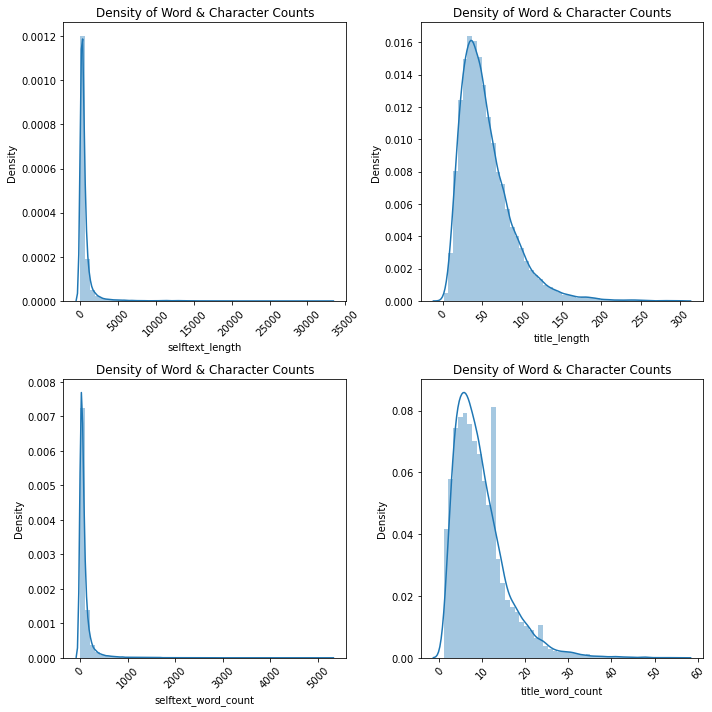

In [14]:
# Plotting the distrubtion of word count/char count
plt.figure(figsize=(10,10))
for i in enumerate(df.columns[9:13]):
    plt.subplot(2,2, i[0]+1)
    ax = sns.distplot(df[i[1]])
    plt.xticks(rotation = 45)
    ax.set_title('Density of Word & Character Counts')
    plt.tight_layout()

This plot shows that most posts on these two subreddits distributions range from around 1-15 words and about 10-60 characters.

### Setting up data for modeling <a class="anchor" id="third-bullet"></a>

In [15]:
X = df['selftext']
y = df['subreddit']

In [16]:
# Split data into the training and testing sets.
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y,stratify=y)

In [17]:
#Instantiate a CountVectorizer with a default hyperparamters

cvec = CountVectorizer(stop_words='english')

In [18]:
# Fit and transform train

X_train1 = cvec.fit_transform(X_train1)

# Transform the corpus.

X_test1 = cvec.transform(X_test1)

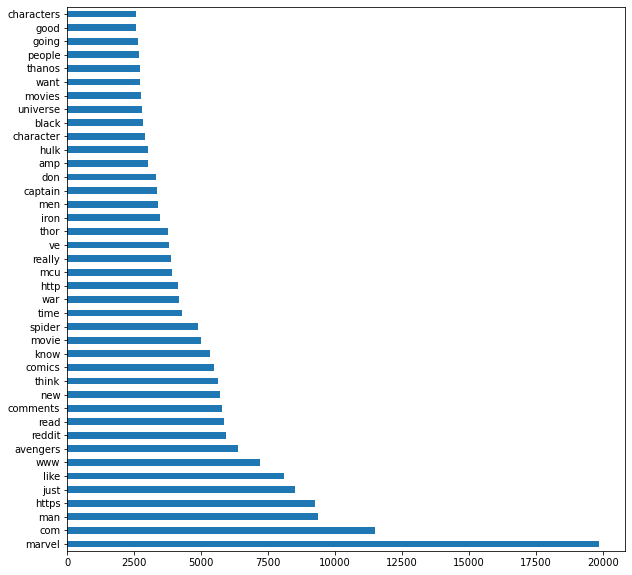

In [19]:
# Plotting most used words

X_train1_df = pd.DataFrame(X_train1.todense(),
                         columns = cvec.get_feature_names())

plt.figure(figsize=(10,10))
X_train1_df.sum().sort_values(ascending=False).head(40).plot(kind='barh');

This plot illustrates that the stop words need to be customized in order because words like http, https, www are hyper links that give no distinction between the two subreddits.

In [20]:
# Creating a list of words to ommit

my_words = ['characters', 'good','going','people','want','character','men','http','time','know','think',
            'new','reddit','avengers','www','like','just','https','man','com','marvel']

# Adding them to stop_words

stop_words = text.ENGLISH_STOP_WORDS.union(my_words)

In [21]:
# Initialize fresh train and test data

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### Baseline accuracy <a class="anchor" id="fourth-bullet"></a>

Calculating the baseline accuracy

In [22]:
y_test.value_counts(normalize=True)

marvelstudios    0.516543
Marvel           0.483457
Name: subreddit, dtype: float64

## Modeling with CountVect and Multinomial Naive Bayes <a class="anchor" id="fifth-bullet"></a>

Using CountVectorizer is one of the easier ways to turn X into a numeric dataframe. The function counts each time a token is used.

Multinomial Naive Bayes relies on the Bayes theorem.
$$
\begin{eqnarray*}
\text{Bayes' Theorem: } P(A|B) &=& \frac{P(B|A)P(A)}{P(B)}
\end{eqnarray*}
$$

### Let's set a pipeline up with two stages:

In [23]:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

pipe = Pipeline([
    ('cvect', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [24]:
pipe_params = {
    'cvect__max_features': [2000, 3000, 4000, 5000], # Capping features
    'cvect__min_df': [2, 3], # Word has to show up in more than 2-3 documents
    'cvect__max_df': [.9, .95], # Word can't show up in 90% and 95%
    'cvect__ngram_range': [(1,1), (1,2)], # 1-gram, 2-gram
    'cvect__stop_words': [None, 'english',stop_words], # Using stop_words
}

In [25]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1,
                 n_jobs = -2) # 5-fold cross-validation.

In [26]:
# Fit GridSearch to training data.

gs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 420 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done 480 out of 480 | elapsed:  3.5min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvect', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-2,
             param_grid={'cvect__max_df': [0.9, 0.95],
                         'cvect__max_features': [2000, 3000, 4000, 5000],
                         'cvect__min_df': [2, 3],
                         'cvect__ngram_range': [(1, 1), (1, 2)],
                         'cvect__stop_words': [None, 'english',
                                               frozenset({'a', 'about', 'above',
                                                          'across', 'after',
                                                          'afterwards', 'again',
                                                          'against', 'all',
                                                          'almost', 'alone',
                                                          'along', 'already',
                                            

In [27]:
# Scoring Metrics:


# Accuracy scores
gs.score(X_train,y_train), gs.score(X_test,y_test)

(0.7902685428586156, 0.7772108843537415)

In [28]:
# Mean of cv scores
gs.best_score_

0.7780534297409797

In [29]:
# Models favorite params
gs.best_params_

{'cvect__max_df': 0.9,
 'cvect__max_features': 5000,
 'cvect__min_df': 3,
 'cvect__ngram_range': (1, 1),
 'cvect__stop_words': frozenset({'a',
            'about',
            'above',
            'across',
            'after',
            'afterwards',
            'again',
            'against',
            'all',
            'almost',
            'alone',
            'along',
            'already',
            'also',
            'although',
            'always',
            'am',
            'among',
            'amongst',
            'amoungst',
            'amount',
            'an',
            'and',
            'another',
            'any',
            'anyhow',
            'anyone',
            'anything',
            'anyway',
            'anywhere',
            'are',
            'around',
            'as',
            'at',
            'avengers',
            'back',
            'be',
            'became',
            'because',
            'become',
            'becomes',


In [30]:
# Make predictions:

gs_y_pred = gs.predict(X_test)

In [31]:
# Accuracy matrix

gs_tn, gs_fp, gs_fn, gs_tp = confusion_matrix(y_test, gs_y_pred).ravel()

In [32]:
gs_tn, gs_fp, gs_fn, gs_tp

(2009, 1118, 323, 3018)

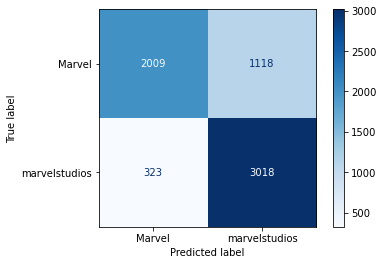

In [33]:
plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

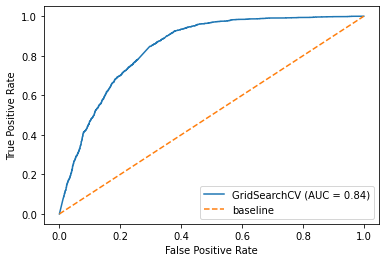

In [41]:
# ROC curve
plot_roc_curve(gs, 
               X_test, 
               y_test)
# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")
# add a legend
plt.legend();

True Positive Rate vs. False Positive Rate the area under the curve quantifies the gap between our distributions.

#### The CountVectorizer ran with a Multinomial Naive Bayes model has an accuracy score of 76.3% and 76.1% which is a decently fit model and produces high number of Type I errors depicted in the confusion matrix above. The model performs semi-well with predictions on the test data.

## Modeling with TfidfVect and Logistic Regression <a class="anchor" id="sixth-bullet"></a>

In [43]:
# 1. TfidfVectorizer (transformer)
# 2. Logistic Regression (estimator)


pipey = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [44]:
pipe_tvec_params = {
    'tvec__max_features': [3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english',stop_words],
    'tvec__ngram_range': [(1,1), (1,2)],
    'tvec__max_df': [.9, .92],
    'tvec__min_df': [2,4],
    'logreg__C': np.linspace(0.00001,2,10),
    'logreg__penalty': ['l1', 'l2']
}

In [45]:
# Instantiate GridSearchCV.

gsv = GridSearchCV(pipey, # what object are we optimizing?
                  param_grid=pipe_tvec_params, # what parameters values are we searching?
                  cv=5, verbose = 1,
                 n_jobs = -1) # 5-fold cross-validation.

In [46]:
# Fit and wait

gsv.fit(X_train,y_train)

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed: 25.9min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed: 39.8min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 47.6min
[Parallel(n_jobs=-1)]: Done 7200 out of 7200 | elapsed: 47.8min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logreg__C': array([1.00000000e-05, 2.22231111e-01, 4.44452222e-01, 6.66673333e-01,
       8.88894444e-01, 1.11111556e+00, 1.33333667e+00, 1.55555778e+00,
       1.77777889e+00, 2.00000000e+00]),
                         'logreg__penalty': ['l1', 'l2'],
                         'tvec__max_df': [0.9, 0....
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english',
                                              frozenset({'a', 'about', 'above',
                                                         'across', 'after',
                                                         'afterwards', 'again',
                                                         'against', 'all',
                                            

In [47]:
# Scoring Metrics:

gsv.best_score_

0.7899595040070977

In [48]:
# The models favorite params
gsv.best_params_

{'logreg__C': 1.1111155555555556,
 'logreg__penalty': 'l2',
 'tvec__max_df': 0.9,
 'tvec__max_features': 5000,
 'tvec__min_df': 4,
 'tvec__ngram_range': (1, 2),
 'tvec__stop_words': None}

In [49]:
# Acurracy Scores
gsv.score(X_train,y_train), gsv.score(X_test,y_test)

(0.8377918663986392, 0.7840136054421769)

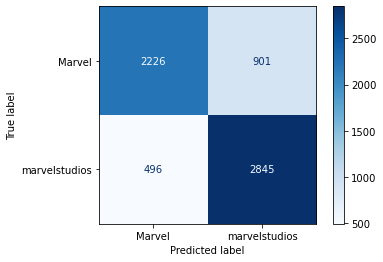

In [50]:
# Plot Confusion Matrix for SVM Model

plot_confusion_matrix(gsv, X_test, y_test, cmap='Blues', values_format='d');

In [51]:
# Make Predictions

gsv_y_pred = gsv.predict(X_test)

In [52]:
# Confusion Matrix

gsv_tn, gsv_fp, gsv_fn, gsv_tp = confusion_matrix(y_test, gsv_y_pred).ravel()

In [53]:
gsv_tn, gsv_fp, gsv_fn, gsv_tp

(2226, 901, 496, 2845)

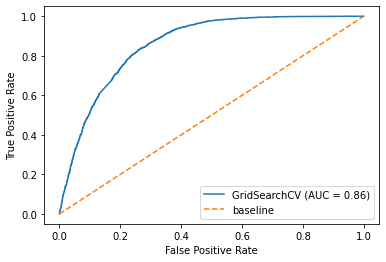

In [54]:
# ROC curve
plot_roc_curve(gsv, 
               X_test, 
               y_test)
# add worst case scenario line
plt.plot([0,1], [0,1], label = "baseline", linestyle = "--")
# add a legend
plt.legend();

True Positive Rate vs. False Positive Rate the area under the curve quantifies the gap between our distributions.

#### TfdifVectorizer ran with a Logistic Regression actually improves the score and is the better of the two models. TfidfVectorizer uses a score of each vectorized word instead of getting a count like with CountVectorizer. Logistic Regression generates the coefficients of a formula to predict a logit transformation of the probability. Of the two models LogisticRegression scores 82.1% on train data and 79.5% on testing data. This model effective reduces predictive errors.

## Executive Summary <a class="anchor" id="seventh-bullet"></a>

#### Between the two models, TfdifVectorizer ran with a Logistic Regression improves the accuracy scores on test data with a slight bit of overfitting on train data. The CountVectorizer ran with Naive Bayes runs very similarly across test and training data but is less accurate. TfdifVectorizer ran with Logistic Regression would be the model of choice with significantly low runtime. After this project, I'll reuse this data to run through all the different tendencies of each model. Originally, I ran a SVC model that wanted to take longer than 24 hours to fit.